# Importation des bases

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


In [2]:
# Data

## Customers 
customers_account_activity = pd.read_csv("https://raw.githubusercontent.com/LarrySANDJO/PROJET_STATAPP/refs/heads/Branche_Larry_Balthazar/Data/Raws/account_activity.csv")
customers_customer_data = pd.read_csv("https://raw.githubusercontent.com/LarrySANDJO/PROJET_STATAPP/refs/heads/Branche_Larry_Balthazar/Data/Raws/customer_data.csv")

## Fraudulents Patterns
fraud_fraud_indicators = pd.read_csv("https://raw.githubusercontent.com/LarrySANDJO/PROJET_STATAPP/refs/heads/Branche_Larry_Balthazar/Data/Raws/fraud_indicators.csv")
fraud_suspicious_activity = pd.read_csv("https://raw.githubusercontent.com/LarrySANDJO/PROJET_STATAPP/refs/heads/Branche_Larry_Balthazar/Data/Raws/suspicious_activity.csv")

## Merchant
merchants_merchant_data = pd.read_csv("https://raw.githubusercontent.com/LarrySANDJO/PROJET_STATAPP/refs/heads/Branche_Larry_Balthazar/Data/Raws/merchant_data.csv")
merchants_transaction_category_labels = pd.read_csv("https://raw.githubusercontent.com/LarrySANDJO/PROJET_STATAPP/refs/heads/Branche_Larry_Balthazar/Data/Raws/transaction_category_labels.csv")

## Transactions Amount
transactions_amount_data = pd.read_csv("https://raw.githubusercontent.com/LarrySANDJO/PROJET_STATAPP/refs/heads/Branche_Larry_Balthazar/Data/Raws/amount_data.csv")
transactions_anomaly_scores = pd.read_csv("https://raw.githubusercontent.com/LarrySANDJO/PROJET_STATAPP/refs/heads/Branche_Larry_Balthazar/Data/Raws/anomaly_scores.csv")

## Transactions Data
transactions_data_records = pd.read_csv("https://raw.githubusercontent.com/LarrySANDJO/PROJET_STATAPP/refs/heads/Branche_Larry_Balthazar/Data/Raws/transaction_records.csv")
transactions_data_metadata= pd.read_csv("https://raw.githubusercontent.com/LarrySANDJO/PROJET_STATAPP/refs/heads/Branche_Larry_Balthazar/Data/Raws/transaction_metadata.csv")

### Fusion des donnees

In [3]:
df = customers_account_activity
df = df.merge(customers_customer_data, on = "CustomerID")
df = df.merge(transactions_data_records, on = "CustomerID")
df = df.merge(transactions_data_metadata, on = "TransactionID")
df = df.merge(merchants_transaction_category_labels, on = "TransactionID")
df = df.merge(merchants_merchant_data, on = "MerchantID")
df = df.merge(transactions_amount_data, on = "TransactionID")
df = df.merge(transactions_anomaly_scores, on = "TransactionID")
df = df.merge(fraud_suspicious_activity, on = "CustomerID")
df = df.merge(fraud_fraud_indicators, on = "TransactionID")
df.head(4)


,CustomerID,AccountBalance,LastLogin,Name,Age,Address,TransactionID,Amount,Timestamp,MerchantID,Category,MerchantName,Location,TransactionAmount,AnomalyScore,SuspiciousFlag,FraudIndicator
0,1001,9507.272060,2022-01-01,Customer 1001,54,Address 1001,787,33.670626,2022-02-02 18:00:00,2627,Food,Merchant 2627,Location 2627,87.375444,0.030921,0,0
1,1003,1715.321989,2022-01-03,Customer 1003,40,Address 1003,641,30.980239,2022-01-27 16:00:00,2496,Travel,Merchant 2496,Location 2496,46.044172,0.961552,0,0
2,1004,3101.509134,2022-01-04,Customer 1004,30,Address 1004,450,11.167088,2022-01-19 17:00:00,2184,Other,Merchant 2184,Location 2184,85.085061,0.525809,0,0
3,1004,3101.509134,2022-01-04,Customer 1004,30,Address 1004,921,45.849784,2022-02-08 08:00:00,2111,Other,Merchant 2111,Location 2111,36.534720,0.652188,0,0


### Save the whole dataset

In [4]:
df.to_csv("/home/onyxia/PROJET_STATAPP/Data/Raws/Raw_data.csv", sep = "," )

# Nettoyage du dataset

## Valeurs manquantes

In [5]:
import missingno as msno

<Axes: >

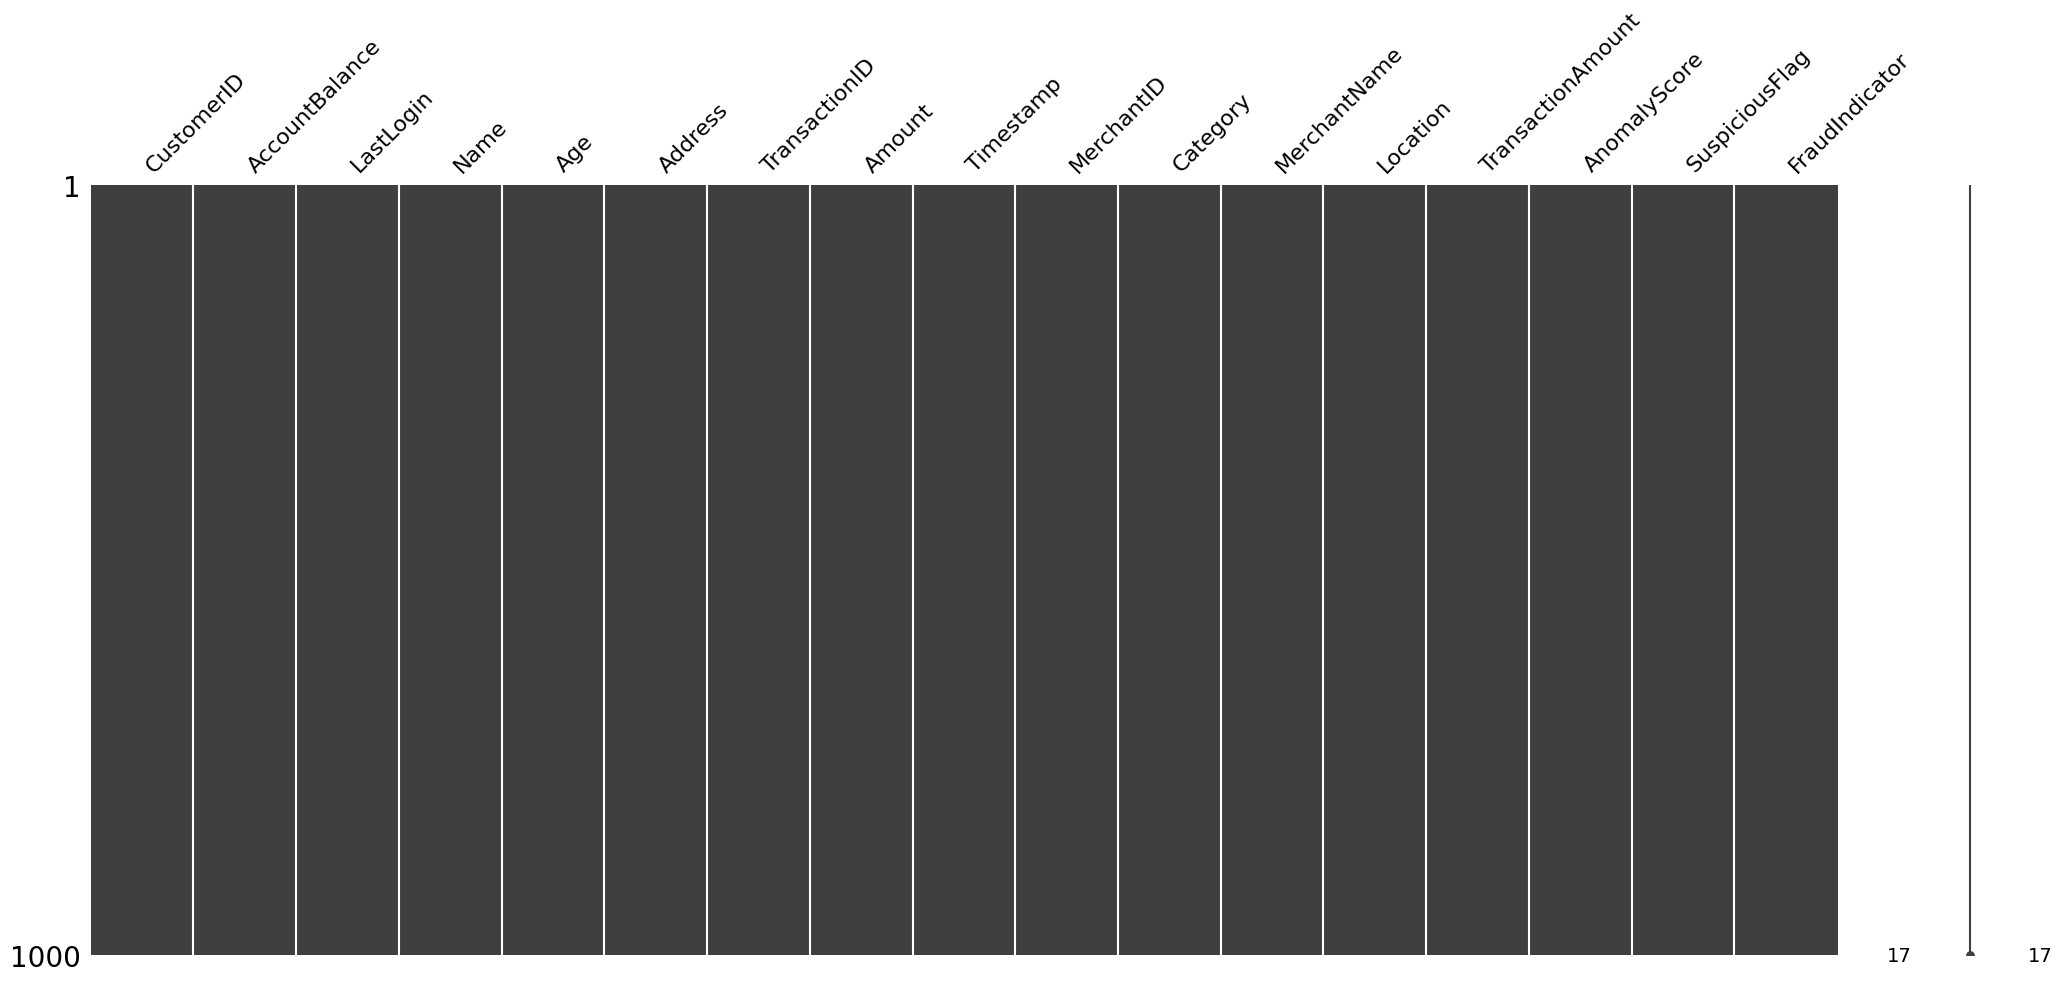

In [6]:
msno.matrix(df)

Aucune valeur manquante apparente

## Valeurs aberantes

In [7]:
df = df.drop(columns = ["TransactionID", "CustomerID", "MerchantID", "Address"]).reset_index(drop = True)

In [8]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Jour'] = df['Timestamp'].dt.day_name()      # nom du jour : Monday, Tuesday, etc.
df['Mois'] = df['Timestamp'].dt.month_name()    # nom du mois : January, February, etc.
df['Heure'] = df['Timestamp'].dt.hour

In [9]:
df.to_csv("/home/onyxia/PROJET_STATAPP/Data/Cleans/Clean_data.csv", sep = "," )

In [10]:
colonnes_cat = ["Category", "Jour", "Mois", "Heure"]
colonnes_num = df.select_dtypes(include='number').columns.tolist()

In [11]:
colonnes_num

['AccountBalance',
 'Age',
 'Amount',
 'TransactionAmount',
 'AnomalyScore',
 'SuspiciousFlag',
 'FraudIndicator',
 'Heure']

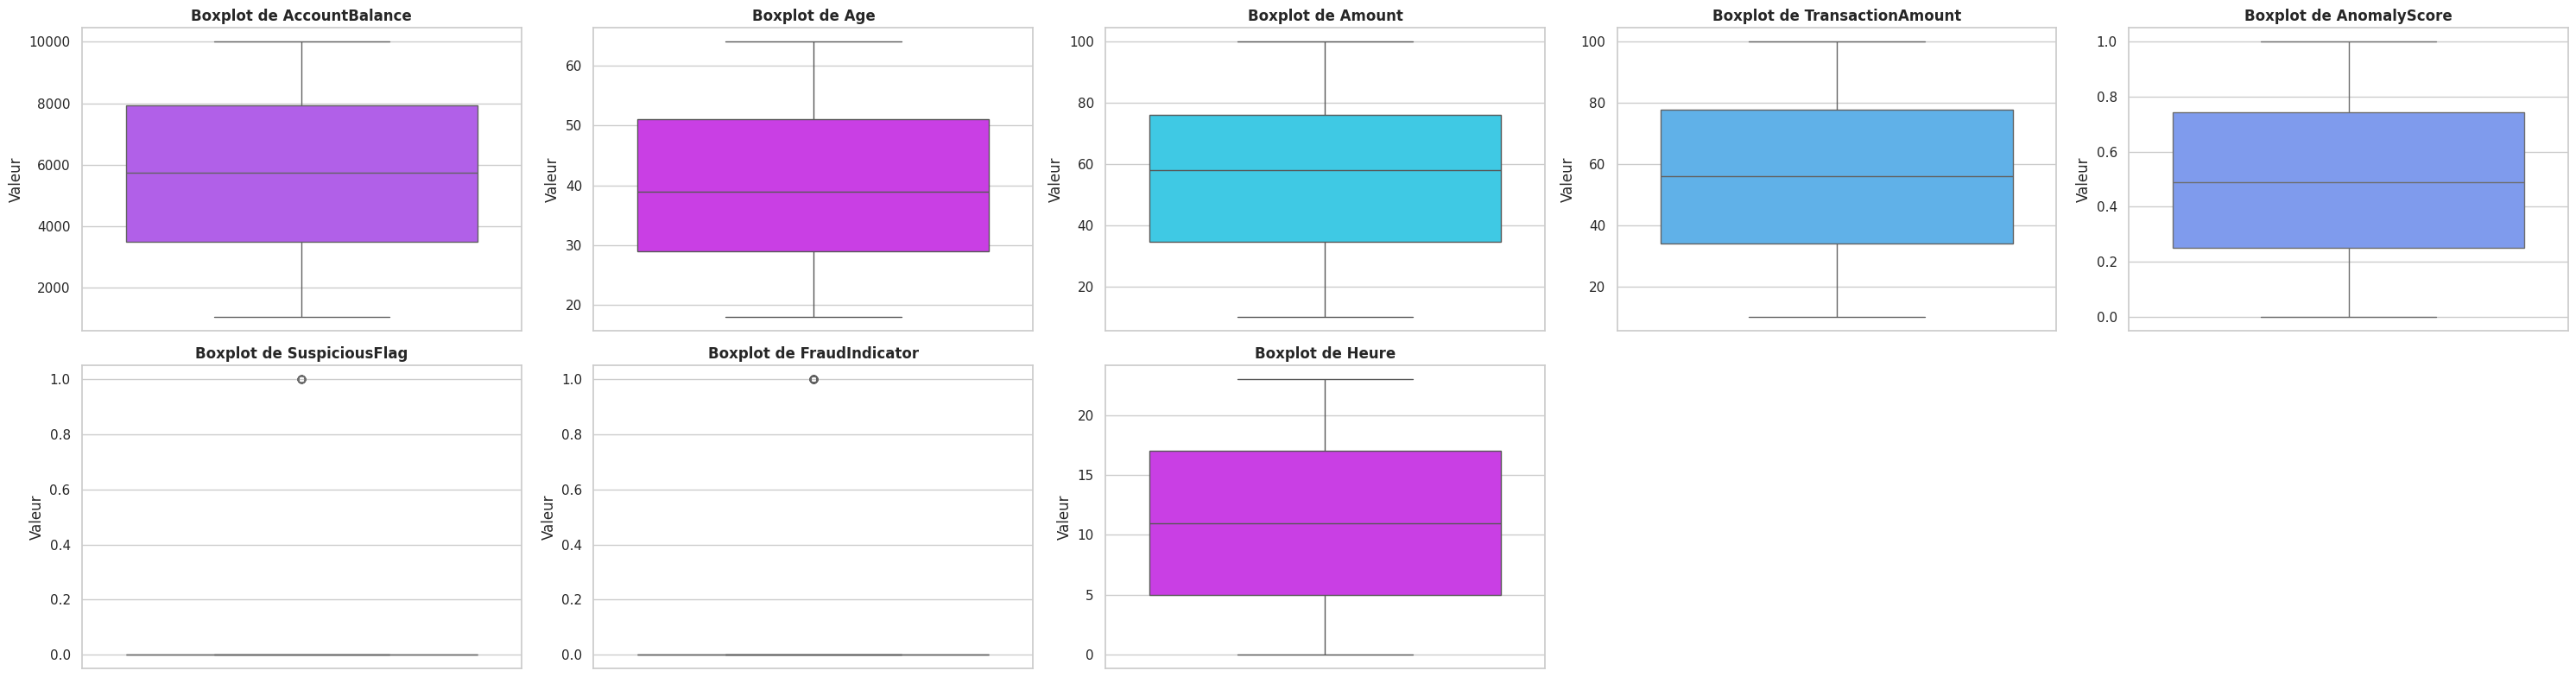

In [12]:
n = len(colonnes_num)
cols = 5
rows = math.ceil(n / cols)

plt.figure(figsize=(6 * cols, 4 * rows))
sns.set_theme(style="whitegrid")

for i, col in enumerate(colonnes_num, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y=df[col], color=sns.color_palette("cool")[i-3 % 10])
    plt.title(f'Boxplot de {col}', fontsize=12, weight='bold')
    plt.xlabel('')
    plt.ylabel('Valeur')

plt.tight_layout()
plt.show()

Aucun outlier apparent

# Statistiques descriptives preliminaires des variables 

In [13]:
df.describe()

,AccountBalance,Age,Amount,Timestamp,TransactionAmount,AnomalyScore,SuspiciousFlag,FraudIndicator,Heure
count,1000.000000,1000.000000,1000.000000,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5715.455931,39.848000,55.394871,2022-01-21 19:30:00,55.853826,0.492282,0.025000,0.045000,11.436000
min,1056.301181,18.000000,10.006933,2022-01-01 00:00:00,10.057864,0.000234,0.000000,0.000000,0.000000
25%,3489.554711,29.000000,34.502315,2022-01-11 09:45:00,33.875129,0.251802,0.000000,0.000000,5.000000
50%,5753.007775,39.000000,57.844325,2022-01-21 19:30:00,55.958313,0.490242,0.000000,0.000000,11.000000
75%,7925.710167,51.000000,75.858576,2022-02-01 05:15:00,77.589391,0.741888,0.000000,0.000000,17.000000
max,9999.776239,64.000000,99.887410,2022-02-11 15:00:00,99.784323,0.999047,1.000000,1.000000,23.000000
std,2540.517262,13.074932,25.070809,NaN,26.093606,0.288423,0.156203,0.207408,6.913009


In [14]:
Y = df["FraudIndicator"]
X = df.drop(columns = "FraudIndicator")
X.head(4)

,AccountBalance,LastLogin,Name,Age,Amount,Timestamp,Category,MerchantName,Location,TransactionAmount,AnomalyScore,SuspiciousFlag,Jour,Mois,Heure
0,9507.272060,2022-01-01,Customer 1001,54,33.670626,2022-02-02 18:00:00,Food,Merchant 2627,Location 2627,87.375444,0.030921,0,Wednesday,February,18
1,1715.321989,2022-01-03,Customer 1003,40,30.980239,2022-01-27 16:00:00,Travel,Merchant 2496,Location 2496,46.044172,0.961552,0,Thursday,January,16
2,3101.509134,2022-01-04,Customer 1004,30,11.167088,2022-01-19 17:00:00,Other,Merchant 2184,Location 2184,85.085061,0.525809,0,Wednesday,January,17
3,3101.509134,2022-01-04,Customer 1004,30,45.849784,2022-02-08 08:00:00,Other,Merchant 2111,Location 2111,36.534720,0.652188,0,Tuesday,February,8


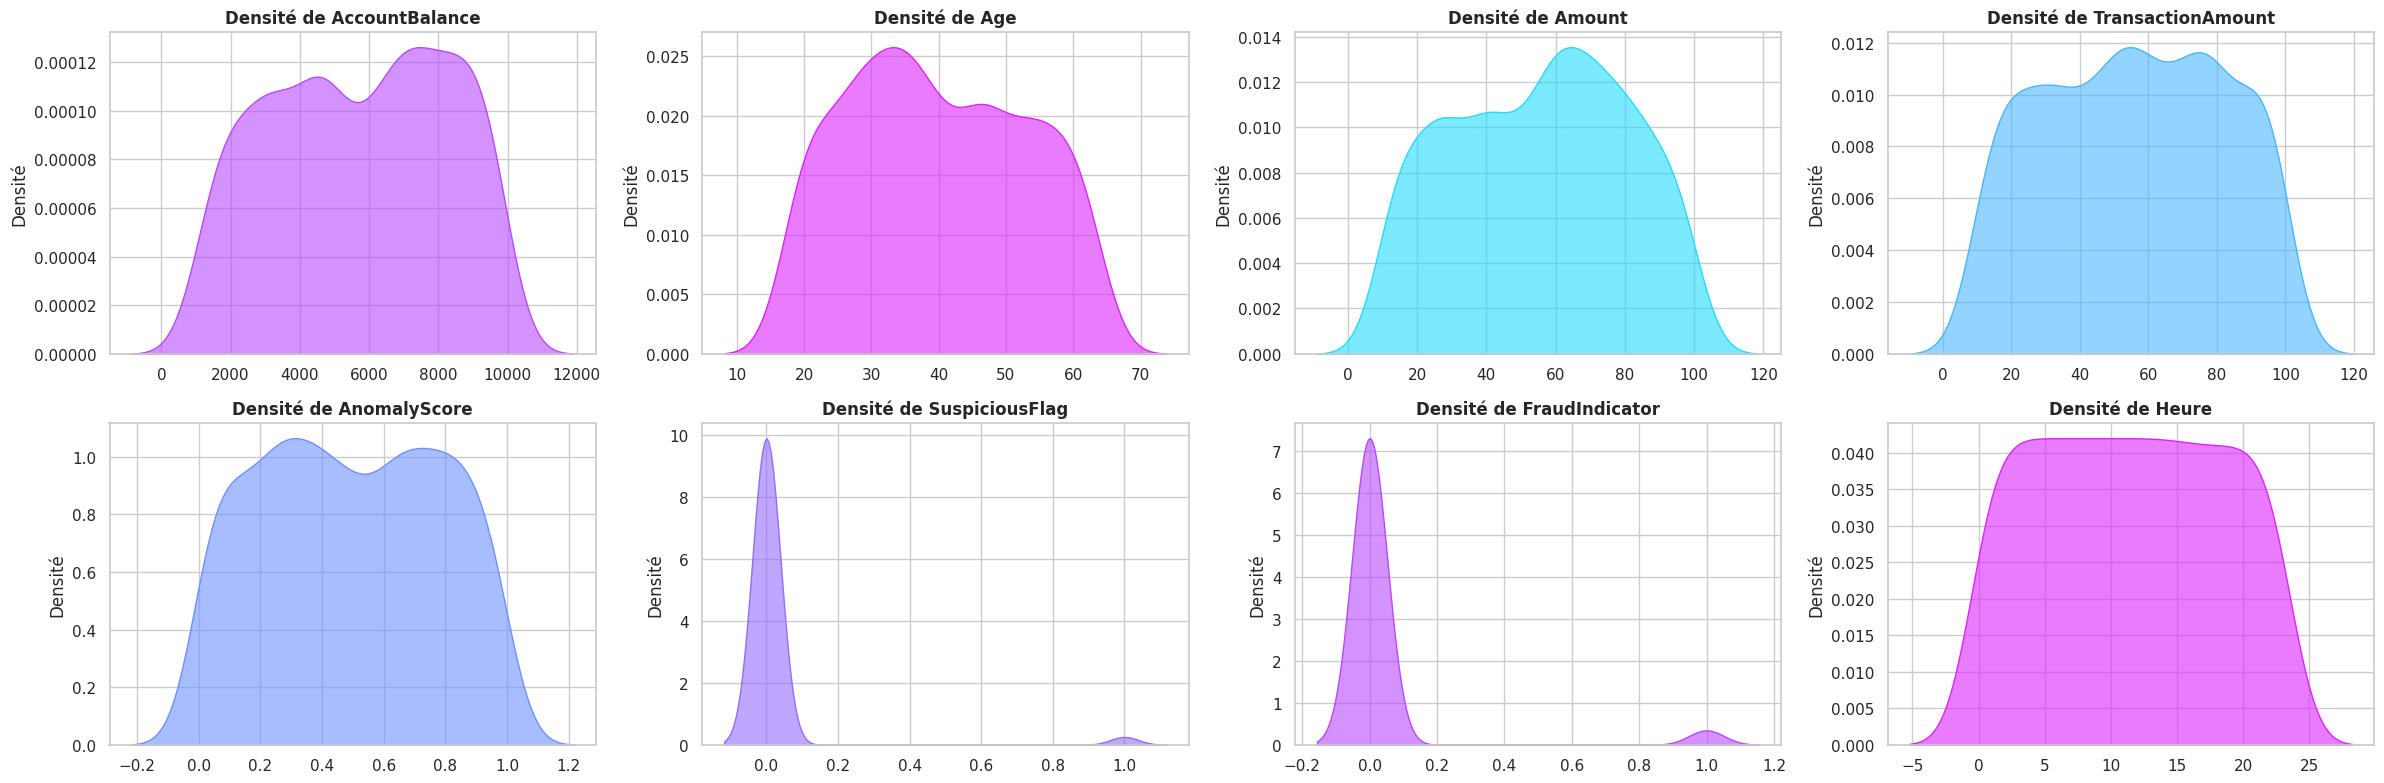

In [15]:
n_num = len(colonnes_num)
cols = 4
rows = math.ceil(n_num / cols)

plt.figure(figsize=(6 * cols, 4 * rows))
for i, col in enumerate(colonnes_num, 1):
    plt.subplot(rows, cols, i)
    sns.kdeplot(data=df, x=col, fill=True, color=sns.color_palette("cool")[i-3 % 10], alpha=0.6)
    plt.title(f'Densité de {col}', fontsize=12, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Densité')

plt.tight_layout()
plt.show()

/tmp/ipykernel_317311/2776610167.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="pastel")
/tmp/ipykernel_317311/2776610167.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="pastel")
/tmp/ipykernel_317311/2776610167.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="pastel")
/tmp/ipykernel_317311/2776610167.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set

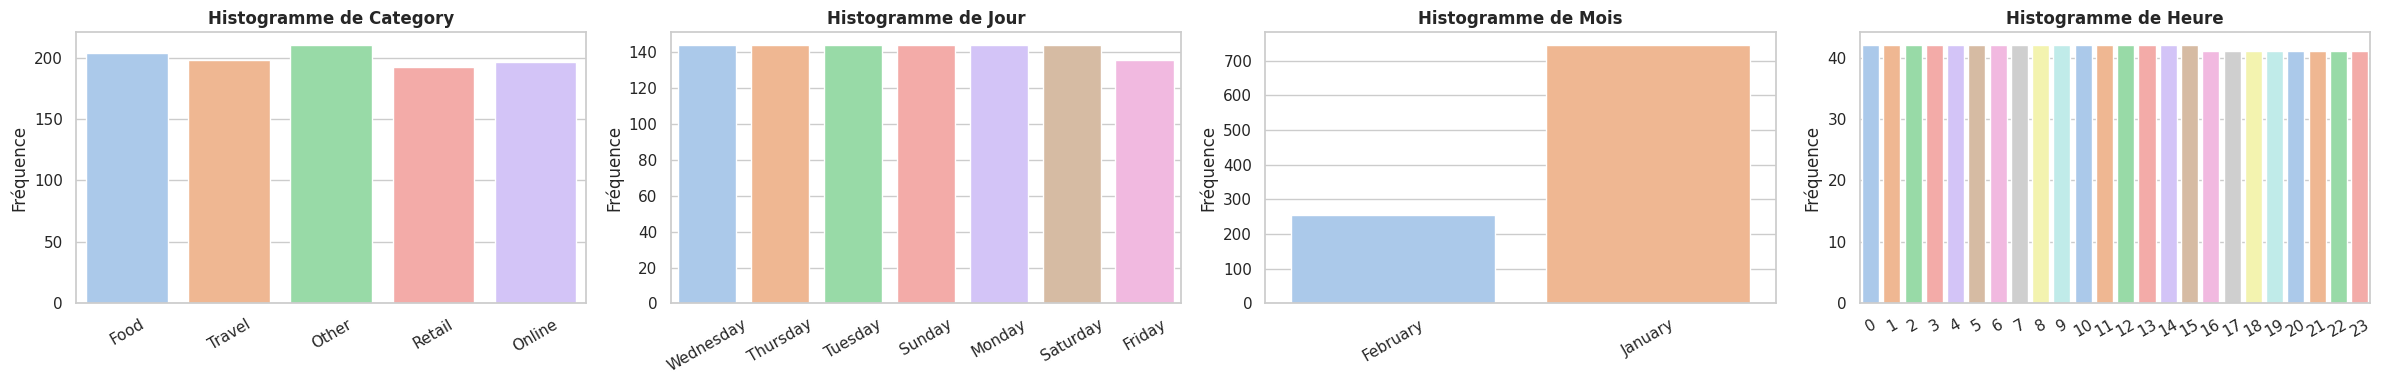

In [16]:
n_cat = len(colonnes_cat)
rows = math.ceil(n_cat / cols)

plt.figure(figsize=(6 * cols, 4 * rows))
for i, col in enumerate(colonnes_cat, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(data=df, x=col, palette="pastel")
    plt.title(f'Histogramme de {col}', fontsize=12, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Fréquence')
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

In [17]:
df['match'] = df['SuspiciousFlag'] == df['FraudIndicator']

# Pourcentage de concordance
concordance = df['match'].mean() * 100
print(f"Taux de concordance : {concordance:.2f}%")

Taux de concordance : 93.60%


/tmp/ipykernel_317311/1592792969.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Y.map({0: 'Non fraude', 1: 'Fraude'}), palette="pastel")


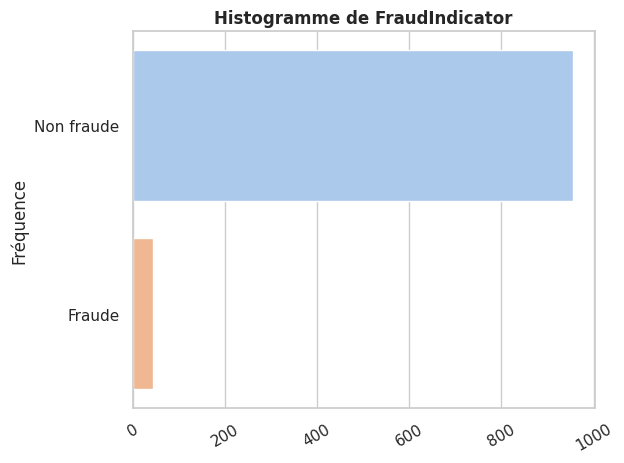

In [18]:
sns.countplot(data=Y.map({0: 'Non fraude', 1: 'Fraude'}), palette="pastel")
plt.title(f'Histogramme de {"FraudIndicator"}', fontsize=12, fontweight='bold')
plt.xlabel('')
plt.ylabel('Fréquence')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [19]:
Y.mean()*100

np.float64(4.5)

On a donc 4.5% de Fraude

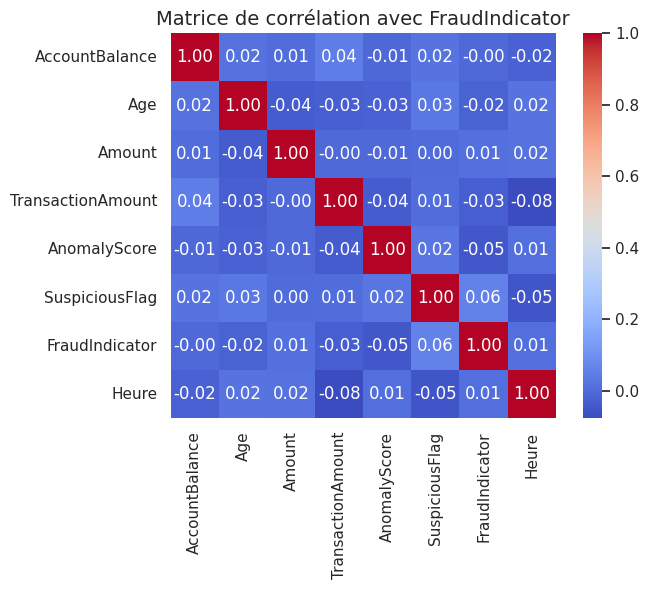

In [20]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matrice de corrélation avec FraudIndicator", fontsize=14)
plt.show()

Aucune variable n'est tres correlee a la variable d'interet; on va ainsi travailler avec toutes

## Separation des donnees en train et test

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.2, 
    random_state=42,
    stratify=Y   
)

print(f"Dimensions de X_train : {X_train.shape}")
print(f"Dimensions de X_test  : {X_test.shape}")
print(f"Répartition dans y_train :\n{y_train.value_counts(normalize=True)}")
print(f"Répartition dans y_test  :\n{y_test.value_counts(normalize=True)}")

Dimensions de X_train : (800, 15)
Dimensions de X_test  : (200, 15)
Répartition dans y_train :
FraudIndicator
0    0.955
1    0.045
Name: proportion, dtype: float64
Répartition dans y_test  :
FraudIndicator
0    0.955
1    0.045
Name: proportion, dtype: float64


## Pipeline de preparation des donnees

In [22]:
# Extraction des features
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(exclude=['int64', 'float64']).columns

print(num_features, cat_features)

Index(['AccountBalance', 'Age', 'Amount', 'TransactionAmount', 'AnomalyScore',
       'SuspiciousFlag'],
      dtype='object') Index(['LastLogin', 'Name', 'Timestamp', 'Category', 'MerchantName',
       'Location', 'Jour', 'Mois', 'Heure'],
      dtype='object')


In [23]:
# Construction du pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # On fait le onehot encoding pour garder le maximum d'information (les features sont faiblement correles a Y)
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

## Rééchantillonnage et test du panel de modeles

In [24]:
# Panel de modeles
models = {
    "Régression Logistique": LogisticRegression(max_iter=1000, random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Bagging": BaggingClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [25]:
results = []

for name, model in models.items():
    print(f"🔹 Entraînement du modèle : {name}")
    
    pipe = ImbPipeline(steps=[
        ('preprocessing', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    y_pred_binary = (y_proba >= 0.5).astype(int)
    
    results.append({
    'Modèle': name,
    'F1-score': f1_score(y_test, y_pred_binary),
    'Précision': precision_score(y_test, y_pred_binary),
    'Rappel': recall_score(y_test, y_pred_binary),
    'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
})

# Résumé
results_df = pd.DataFrame(results).sort_values(by='F1-score', ascending=False)
display(results_df)


🔹 Entraînement du modèle : Régression Logistique
🔹 Entraînement du modèle : Extra Trees


/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


🔹 Entraînement du modèle : Gradient Boosting


/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


🔹 Entraînement du modèle : LightGBM
[LightGBM] [Info] Number of positive: 764, number of negative: 764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5276
[LightGBM] [Info] Number of data points in the train set: 1528, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🔹 Entraînement du modèle : CatBoost


/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


🔹 Entraînement du modèle : Bagging
🔹 Entraînement du modèle : Random Forest


/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/python/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:06:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 Entraînement du modèle : XGBoost


/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Modèle,F1-score,Précision,Rappel,ROC-AUC
5,Bagging,0.166667,0.333333,0.111111,0.610529
0,Régression Logistique,0.000000,0.000000,0.000000,0.525305
2,Gradient Boosting,0.000000,0.000000,0.000000,0.457533
1,Extra Trees,0.000000,0.000000,0.000000,0.528796
3,LightGBM,0.000000,0.000000,0.000000,0.586969
4,CatBoost,0.000000,0.000000,0.000000,0.486911
6,Random Forest,0.000000,0.000000,0.000000,0.546248
7,XGBoost,0.000000,0.000000,0.000000,0.514252


Les resultats sont inquietants

## Nouvelle tentative en supprimant les variables AnomalyScore et SuspiciousFlag

In [26]:
# Colonnes à utiliser après suppression
num_features_filtered = [c for c in num_features if c not in ['AnomalyScore', 'SuspiciousFlag']]
cat_features_filtered = [c for c in cat_features if c not in ['AnomalyScore', 'SuspiciousFlag']]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features_filtered),
    ('cat', cat_pipeline, cat_features_filtered)
], remainder='drop')


In [27]:
results = []

for name, model in models.items():
    print(f"🔹 Entraînement du modèle : {name}")
    
    pipe = ImbPipeline(steps=[
        ('preprocessing', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    y_pred_binary = (y_proba >= 0.3).astype(int)
    
    results.append({
    'Modèle': name,
    'F1-score': f1_score(y_test, y_pred_binary),
    'Précision': precision_score(y_test, y_pred_binary),
    'Rappel': recall_score(y_test, y_pred_binary),
    'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
})

# Résumé
results_df = pd.DataFrame(results).sort_values(by='F1-score', ascending=False)
display(results_df)


🔹 Entraînement du modèle : Régression Logistique
🔹 Entraînement du modèle : Extra Trees
🔹 Entraînement du modèle : Gradient Boosting
🔹 Entraînement du modèle : LightGBM
[LightGBM] [Info] Number of positive: 764, number of negative: 764
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4999
[LightGBM] [Info] Number of data points in the train set: 1528, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/opt/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


🔹 Entraînement du modèle : CatBoost
🔹 Entraînement du modèle : Bagging
🔹 Entraînement du modèle : Random Forest
🔹 Entraînement du modèle : XGBoost


/opt/python/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:06:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Modèle,F1-score,Précision,Rappel,ROC-AUC
7,XGBoost,0.200000,1.000000,0.111111,0.465969
5,Bagging,0.190476,0.166667,0.222222,0.562245
0,Régression Logistique,0.000000,0.000000,0.000000,0.490983
1,Extra Trees,0.000000,0.000000,0.000000,0.486038
3,LightGBM,0.000000,0.000000,0.000000,0.561373
2,Gradient Boosting,0.000000,0.000000,0.000000,0.466259
4,CatBoost,0.000000,0.000000,0.000000,0.470622
6,Random Forest,0.000000,0.000000,0.000000,0.575044


Tres legeres ameliorations

## Focus sur XGBoost avec validation croisee

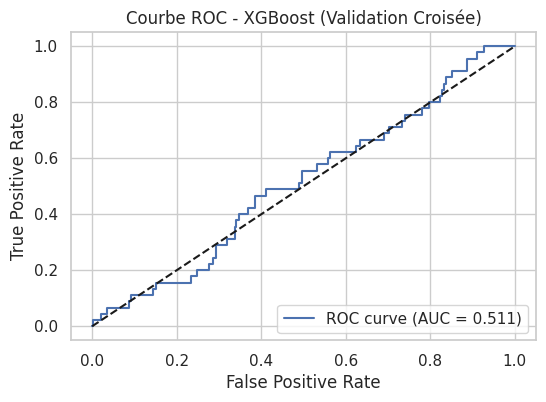

In [28]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

pipe = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', xgb_model)
])

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predictions
y_pred_cv = cross_val_predict(pipe, X, Y, cv=cv, method='predict')
y_proba_cv = cross_val_predict(pipe, X, Y, cv=cv, method='predict_proba')[:, 1]

# Courbe ROC
fpr, tpr, thresholds = roc_curve(Y, y_proba_cv)
roc_auc = roc_auc_score(Y, y_proba_cv)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC - XGBoost (Validation Croisée)')
plt.legend(loc='lower right')
plt.show()

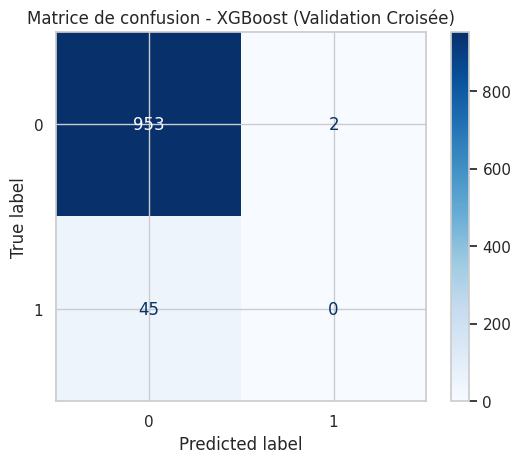

In [29]:
# Matrice de confusion
labels = np.unique(Y)

cm = confusion_matrix(Y, y_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion - XGBoost (Validation Croisée)")
plt.show()

In [30]:
# Classification report
print("Classification Report - XGBoost (Validation Croisée):\n")
print(classification_report(Y, y_pred_cv))

Classification Report - XGBoost (Validation Croisée):

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       955
           1       0.00      0.00      0.00        45

    accuracy                           0.95      1000
   macro avg       0.48      0.50      0.49      1000
weighted avg       0.91      0.95      0.93      1000



## Implementation de XGBoost avec Indice de Youden

In [31]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

pipe = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', xgb_model)
])

pipe.fit(X_train, y_train)

y_proba = pipe.predict_proba(X_test)[:, 1]

# Calcul de l'indice de Youden et seuil optimal
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
youden_index = tpr - fpr
best_idx = np.argmax(youden_index)
best_threshold = thresholds[best_idx]

print(f"Meilleur seuil selon Youden : {best_threshold:.3f}")

/opt/python/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:06:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Meilleur seuil selon Youden : 0.054


In [32]:
y_pred_new = (y_proba >= best_threshold).astype(int)

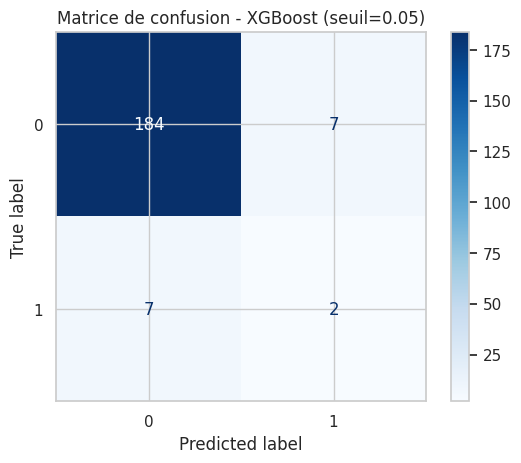

In [33]:
# Matrice de confusion 
cm = confusion_matrix(y_test, y_pred_new)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Matrice de confusion - XGBoost (seuil={best_threshold:.2f})")
plt.show()

In [34]:
# Classification report 
print("Classification Report - XGBoost avec seuil optimal :\n")
print(classification_report(y_test, y_pred_new))

Classification Report - XGBoost avec seuil optimal :

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       191
           1       0.22      0.22      0.22         9

    accuracy                           0.93       200
   macro avg       0.59      0.59      0.59       200
weighted avg       0.93      0.93      0.93       200



/tmp/ipykernel_317311/3875626198.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(tpr, fpr)


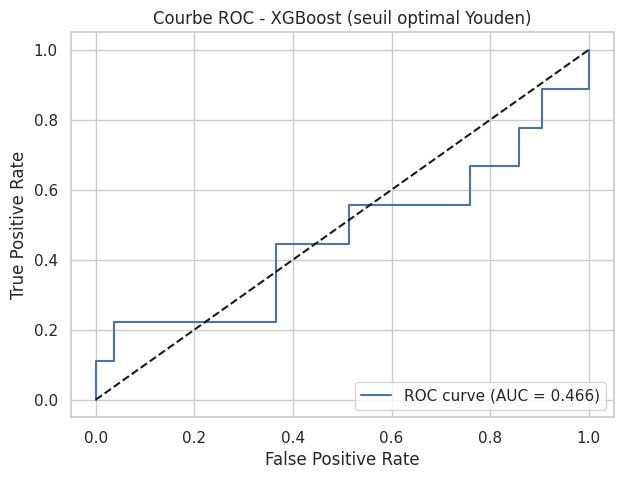

In [35]:
# Courbe ROC
roc_auc = np.trapz(tpr, fpr)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC - XGBoost (seuil optimal Youden)')
plt.legend(loc='lower right')
plt.show()

Amelioration du f1 score qui est passe a 0.22 (macro avg)